In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

from get_metrics import write_metrics_in_csv

In [2]:
# First, be sure to download the dataset
filename: str = 'dataset.csv'
dataset = pd.read_pickle('dataRead_processed.pkl.bz2', compression='bz2')
dataset.shape

(2226, 433)

## Linear regression

In [3]:
dataset.drop(columns=['total_passengers_2015',
                      'total_passengers_and_non_passengers_2022',
                      'total_passengers_and_non_passengers_2015',
                      'total_passengers_and_non_passengers_2022_std',
                      'total_passengers_2022_bx',
                      'total_passengers_and_non_passengers_2022_bx',
                      'total_passengers_2022_BC',
                      'total_passengers_2022_min_max',
                      'total_passengers_and_non_passengers_2022_min_max',
                      'total_passengers_2022_std',
                      ], inplace=True)
dataset.dtypes

city_name                                 object
total_passengers_2022                    float64
city_label                                object
city_category_in_attraction_area_2020      int64
department                                 int64
                                          ...   
city_attraction_area_LUX                 float64
city_size_category_Medium                float64
city_size_category_Small                 float64
Dubious_Yes                              float64
high_population_Low                      float64
Length: 423, dtype: object

In [4]:
# Split the dataset into training and testing sets

X = dataset.loc[:,dataset.columns != 'total_passengers_2022']
y = dataset['total_passengers_2022']

X_train, X_test, y_train, y_test = train_test_split(X, # Features
                                                    y, # Target
                                                    test_size=0.33, # Percentage of the dataset to be used as test set
                                                    random_state=10 # Seed
                                                    )

In [5]:
def minimum_preprocessing(X, y):
    print('Original shape:{}'.format(X.shape))
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    object_columns = X.dtypes[X.dtypes == 'object'].index.values
    # We kill categorical columns
    X=X.drop(columns=categorical_columns)
    X=X.drop(columns=object_columns)
    print('Droped category: {}'.format(categorical_columns))
    print('Droped object: {}'.format(object_columns))
    # We remove missing values
    X=X.dropna()
    y=y[X.index]
    print('New shape:{}'.format(X.shape))
    return X, y

In [6]:
X_train, y_train = minimum_preprocessing(X_train,y_train)
X_test, y_test = minimum_preprocessing(X_test,y_test)

Original shape:(1491, 422)
Droped category: ['population_category']
Droped object: ['city_name' 'city_label']
New shape:(1491, 419)
Original shape:(735, 422)
Droped category: ['population_category']
Droped object: ['city_name' 'city_label']
New shape:(735, 419)


In [7]:
dataset.columns

Index(['city_name', 'total_passengers_2022', 'city_label',
       'city_category_in_attraction_area_2020', 'department', 'region',
       'sum_municipal_population_2021',
       'non_scholarized_15_years_old_or_more_2020', 'main_residences_2020',
       'housing_2020',
       ...
       'city_attraction_area_678', 'city_attraction_area_679',
       'city_attraction_area_BAL', 'city_attraction_area_GEN',
       'city_attraction_area_LAU', 'city_attraction_area_LUX',
       'city_size_category_Medium', 'city_size_category_Small', 'Dubious_Yes',
       'high_population_Low'],
      dtype='object', length=423)

In [8]:
# We instantiate a linear regression. 
lr = LinearRegression() # From sklearn

# Fit the model using the training set
lr.fit(X_train,y_train)

# Predict the target using the training set
y_pred = lr.predict(X_train)

weights = lr.coef_
intercept = lr.intercept_
# You can access to some info about the model, like the weights.
print('Coefficients: \n', weights[:10])
print('Intercept: \n', intercept)

Coefficients: 
 [-2.76607405e+04  4.18025335e+03 -1.08229522e+04 -5.01577617e-01
  1.47816177e+00  5.14943766e+00 -2.68751024e+00 -2.60835469e+00
 -1.02518810e+02  3.98865917e+03]
Intercept: 
 6170641.87774768


In [9]:
# You can also use sklearn implementation
mean_square_error_sk = mean_squared_error(y_train, y_pred)
mean_square_error_sk

# MSE is the average of the square of the errors. The larger the number, the larger the error.
norm_mse_sk = 1-r2_score(y_train, y_pred)

R_squared_sk = r2_score(y_train,y_pred) 

mean_square_error_sk, norm_mse_sk, R_squared_sk

(318717892527.7361, 0.22229790770384894, 0.7777020922961511)

### Cross-validation

In [10]:
cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])


kf = KFold(n_splits=5)
i=1
for train_index, test_index in kf.split(X_train):
    print('Split {}: \n\tTest Folds: [{}] \n\tTrain Folds {}'.format(i, i, [j for j in range(1,6) if j != i]))
    
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]
    
    lr = LinearRegression()
    lr.fit(x_train_fold,y_train_fold)
    y_pred_fold = lr.predict(x_test_fold)
    fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)
    print('\tMSE: {} NMSE: {} R2: {}'.format(fold_mse,fold_nmse, fold_r2) )

    cross_val_metrics.loc['Fold {}'.format(i), :] = [fold_mse,fold_nmse, fold_r2]
    i+=1
    
    
cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
cross_val_metrics

Split 1: 
	Test Folds: [1] 
	Train Folds [2, 3, 4, 5]
	MSE: 371480228679.2573 NMSE: 0.3431617108340206 R2: 0.6568382891659794
Split 2: 
	Test Folds: [2] 
	Train Folds [1, 3, 4, 5]
	MSE: 2.620430843519009e+18 NMSE: 2738614.031224439 R2: -2738613.031224439
Split 3: 
	Test Folds: [3] 
	Train Folds [1, 2, 4, 5]
	MSE: 3.2412689712522e+20 NMSE: 175326428.874601 R2: -175326427.874601
Split 4: 
	Test Folds: [4] 
	Train Folds [1, 2, 3, 5]
	MSE: 280635337951.97614 NMSE: 0.2980155314625199 R2: 0.7019844685374801
Split 5: 
	Test Folds: [5] 
	Train Folds [1, 2, 3, 4]
	MSE: 529577162419.84814 NMSE: 0.22690457309963652 R2: 0.7730954269003635


,MSE,norm_MSE,R2
Fold 1,371480228679.257,0.343,0.657
Fold 2,2620430843519008768.0,2738614.031,-2738613.031
Fold 3,324126897125220024320.0,175326428.875,-175326427.875
Fold 4,280635337951.976,0.298,0.702
Fold 5,529577162419.848,0.227,0.773
Mean,65349465830086344704.0,35613008.755,-35613007.755


In [11]:
lr = LinearRegression()
lr.fit(X_train,y_train)
folds_r2 = cross_val_score(lr, X_train,y_train, cv=5, scoring='r2')
lr_r2 = np.mean(folds_r2) 
folds_r2, lr_r2

(array([-2.57446997e+05, -8.96487386e+07,  7.92451148e-01, -7.68707771e+06,
         7.73095427e-01]),
 -19518652.354694806)

### Ridge regression

In [12]:
cross_val_metrics = pd.DataFrame(columns=['MSE', 'norm_MSE', 'R2'])

def get_best_ridge_regression_parameter(hyperparameters: list[float],
                                        X_train: pd.DataFrame,
                                        y_train: pd.Series,
                                        cv=5
                                        ) -> float:
    """
    Cross validation for Ridge regression.
    Parameters:
    hyperparameters: list of lambda values to be tested
    X_train: Training set
    y_train: Target
    cv: Number of folds
    
    return best model hyperparameter
    """
    ridge_cross_val_metrics = pd.DataFrame(columns=['mean MSE', 'mean norm_MSE', 'mean R2'])


    for lambda_val in hyperparameters:
        kf = KFold(n_splits=cv)
        i=1
        cv_mse = []
        cv_nmse = []
        cv_r2 = []
        
        for train_index, test_index in kf.split(X_train):
            print('Hyperparameter: {}\n\tSplit {}: \n\t\tTest Folds: [{}] \n\t\tTrain Folds {}'.format(lambda_val, i, i, [j for j in range(1,6) if j != i]))
            
            x_train_fold = X_train.values[train_index]
            y_train_fold = y_train.values[train_index]
            x_test_fold = X_train.values[test_index,:]
            y_test_fold = y_train.values[test_index]

            lr = Ridge(alpha=lambda_val)
            lr.fit(x_train_fold,y_train_fold)
            y_pred_fold = lr.predict(x_test_fold)
            
            fold_mse = mean_squared_error(y_test_fold, y_pred_fold)
            fold_nmse = 1-r2_score(y_test_fold, y_pred_fold)
            fold_r2 = r2_score(y_test_fold, y_pred_fold)
            cv_mse.append(fold_mse)
            cv_nmse.append(fold_nmse)
            cv_r2.append(fold_r2)
            print('\t\tMSE: {} NMSE: {} R2: {}'.format(fold_mse,fold_nmse, fold_r2) )
        
        ridge_cross_val_metrics.loc['Lambda={}'.format(lambda_val),:] = [np.mean(cv_mse),np.mean(cv_nmse),np.mean(cv_r2)]

    ridge_cross_val_metrics.sort_values(by='mean R2',ascending=False)
    
    # Return the best model
    best_lambda = ridge_cross_val_metrics.idxmax(axis=0)['mean R2']
    
    # Extract number from string
    best_lambda = float(best_lambda.split('=')[1])
    
    return best_lambda

def cross_validation_ridge_regression(best_hyperparameter: float,
                                      X_train: pd.DataFrame,
                                      y_train: pd.Series,
                                      cv=5
                                      ) -> Ridge:
    
    kf = KFold(n_splits=5)
    i=1
    
    for train_index, test_index in kf.split(X_train):        
        x_train_fold = X_train.values[train_index]
        y_train_fold = y_train.values[train_index]
        x_test_fold = X_train.values[test_index,:]
        y_test_fold = y_train.values[test_index]
        
        lr = LinearRegression()
        lr.fit(x_train_fold,y_train_fold)
        y_pred_fold = lr.predict(x_test_fold)
        fold_mse =mean_squared_error(y_test_fold, y_pred_fold)
        fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
        fold_r2 = r2_score(y_test_fold, y_pred_fold)

        cross_val_metrics.loc['Fold {}'.format(i), :] = [fold_mse,fold_nmse, fold_r2]
        i+=1
        
        
    cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
    cross_val_metrics
    return 
    
# lambdas = [1e-10,1e-5,1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
lambdas = np.logspace(start = -4, stop = 1.1, num = 100, base = 10.0)


get_best_ridge_regression_parameter(hyperparameters=lambdas, X_train=X_train, y_train=y_train)


Hyperparameter: 0.0001
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 371457260264.73676 NMSE: 0.34314049333760077 R2: 0.6568595066623992
Hyperparameter: 0.0001
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 599209752115.396 NMSE: 0.6262345136290703 R2: 0.37376548637092966
Hyperparameter: 0.0001
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 383695374733.05707 NMSE: 0.207548156059568 R2: 0.792451843940432
Hyperparameter: 0.0001
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 280625458565.83246 NMSE: 0.2980050402302553 R2: 0.7019949597697447
Hyperparameter: 0.0001
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 529566830075.7394 NMSE: 0.2269001460655884 R2: 0.7730998539344116
Hyperparameter: 0.00011259397496049283
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 371454368555.23267 NMSE: 0.34313782206762733 R2: 0.6568621779323727
Hyperparameter: 0.00011259397496049283
	Split 1: 
		Test Folds

6.957035867889382

In [13]:
# Train model with the best hyperparameter
best_lambda = get_best_ridge_regression_parameter(hyperparameters=lambdas, X_train=X_train, y_train=y_train)

print(f"Best lambda: {best_lambda}")

# Use cross validation
ridge = Ridge(alpha=best_lambda)
ridge.fit(X_train,y_train, )
y_pred = ridge.predict(X_train)


Hyperparameter: 0.0001
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 371457260264.73676 NMSE: 0.34314049333760077 R2: 0.6568595066623992
Hyperparameter: 0.0001
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 599209752115.396 NMSE: 0.6262345136290703 R2: 0.37376548637092966
Hyperparameter: 0.0001
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 383695374733.05707 NMSE: 0.207548156059568 R2: 0.792451843940432
Hyperparameter: 0.0001
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 280625458565.83246 NMSE: 0.2980050402302553 R2: 0.7019949597697447
Hyperparameter: 0.0001
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 529566830075.7394 NMSE: 0.2269001460655884 R2: 0.7730998539344116
Hyperparameter: 0.00011259397496049283
	Split 1: 
		Test Folds: [1] 
		Train Folds [2, 3, 4, 5]
		MSE: 371454368555.23267 NMSE: 0.34313782206762733 R2: 0.6568621779323727
Hyperparameter: 0.00011259397496049283
	Split 1: 
		Test Folds

## Manual implementation

In [14]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)   # computes means and stdevs for each column in X_train
X_train_scaled = scaler.transform(X_train)             # substracts mean and divides by stdev (estimated from training)
X_test_scaled = scaler.transform(X_test)               # substracts mean and divides by stdev (estimated from training)

X_train_scaled[:,0] = 1   # undo transformation for all-1 column
X_test_scaled[:,0] = 1   # undo transformation for all-1 column

print(X_train_scaled.mean(axis=0))
print(X_test_scaled.mean(axis=0))

[ 1.00000000e+00 -1.19138621e-17 -1.00076442e-16  2.97846553e-17
 -7.74401037e-18  1.19138621e-18  4.76554484e-18 -3.57415863e-18
 -3.45502001e-17 -5.00382208e-17 -1.19138621e-17  2.98323107e-15
 -1.14373076e-16  0.00000000e+00  0.00000000e+00  1.07224759e-17
  2.38277242e-18 -7.62487175e-17  6.67176278e-17 -3.48480466e-17
  6.91004002e-17  8.10142623e-17  3.33588139e-17  2.62104966e-17
  2.62104966e-17  7.14831726e-18  0.00000000e+00 -3.81243587e-17
  7.14831726e-18 -2.97846553e-17  4.76554484e-18  1.66794069e-17
 -2.62104966e-17 -3.09760415e-17  9.53108968e-18 -3.93157449e-17
  9.53108968e-18 -2.85932690e-17 -1.19138621e-17 -3.57415863e-18
  7.14831726e-18 -3.69329725e-17  1.19138621e-18  4.28899036e-17
  2.14449518e-17  0.00000000e+00 -2.62104966e-17  1.07224759e-17
  2.38277242e-18 -9.53108968e-18 -1.19138621e-17  1.66794069e-17
 -9.53108968e-18  4.76554484e-18 -1.31052483e-17  2.38277242e-17
  3.09760415e-17  9.53108968e-18  1.42966345e-17 -1.13181690e-17
 -2.38277242e-18  9.53108

In [15]:
from sklearn.metrics import mean_squared_error

lambdas = np.logspace(start = -4, stop = 1.1, num = 100, base = 10.0)
results = []

X = X_train_scaled.copy()
y = y_train.copy()
n = y.shape[0]
d = X.shape[1]


for l in lambdas:
    XtX = X.T @ X
    XtX_inv = np.linalg.inv( XtX + l * np.identity(n=d))
    coefs = (XtX_inv) @ X.T @ y
    hatmat = X @ XtX_inv @ X.T
    trace_hatmat = np.trace(hatmat)
    y_pred = X @ coefs
    
    loocv = 1/n * np.sum([((y.iloc[i] - y_pred[i]) / (1 - hatmat[i,i]))**2 for i in range(n)])
    
    mse = mean_squared_error(y, y_pred)
    gcv = mse / (1 - trace_hatmat/n)**2
    results.append([l, mse, loocv, gcv])

df = pd.DataFrame(results, columns = ['lambda', 'training_mse', 'loocv', 'gcv']) 
df.sort_values(by='loocv')

,lambda,training_mse,loocv,gcv
95,7.833e+00,3.279e+11,4.445e+11,5.571e+11
96,8.820e+00,3.286e+11,4.445e+11,5.578e+11
94,6.957e+00,3.274e+11,4.445e+11,5.565e+11
97,9.930e+00,3.293e+11,4.446e+11,5.587e+11
93,6.179e+00,3.269e+11,4.447e+11,5.559e+11
...,...,...,...,...
20,1.072e-03,3.245e+11,4.510e+11,5.541e+11
16,6.672e-04,3.245e+11,4.510e+11,5.541e+11
14,5.263e-04,3.245e+11,4.511e+11,5.541e+11
10,3.275e-04,3.245e+11,4.511e+11,5.541e+11


<Axes: xlabel='lambda'>

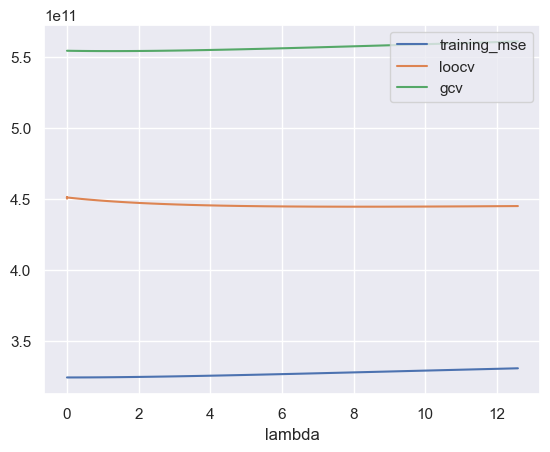

In [16]:
df.plot(kind='line', x='lambda')

In [17]:
best_lambda = df.loc[df['loocv'].idxmin()]['lambda']

print(f'best lambda value: {best_lambda:.4f}')

# apply formula with "best lambda"
theta_vector = np.linalg.inv( X_train_scaled.T @ X_train_scaled + best_lambda * np.identity(n=d)) @ X_train_scaled.T @ y

best lambda value: 7.8332


In [18]:
from sklearn.linear_model import RidgeCV

print(f'there are {X_train_scaled.shape[0]} training examples.')
results = []
for k in range(2, 6+1):
    ridge = RidgeCV(alphas=lambdas, fit_intercept=False, cv=k)   #k-fold cross-val
    clf = ridge.fit(X_train_scaled, y_train)
    results.append([k, clf.alpha_])

## "efficient"  way:
ridge = RidgeCV(alphas=lambdas, fit_intercept=False, cv=None)
clf = ridge.fit(X_train_scaled, y_train)
results.append(['efficient', clf.alpha_])

pd.DataFrame(results, columns=['cross-val method (k)', 'best lambda'])

there are 1491 training examples.


,cross-val method (k),best lambda
0,2,12.589
1,3,12.589
2,4,12.589
3,5,12.589
4,6,12.589
5,efficient,7.833


In [20]:
y_pred = clf.predict(X_test_scaled)

In [21]:
model = 'ridge-regression'
best_lambda = clf.alpha_

hyperparameters = {'alpha': best_lambda}

write_metrics_in_csv(y_pred, y_test, model, hyperparameters)